# Simulating Strong Gravitational Lenses 
In this notebook, we go through the method of simulating strong gravitational lenses with Euclid observation configurations using [Lenstronomy](https://lenstronomy.readthedocs.io/en/latest/). The goal is to generate a dataset of lenses in Euclid-VIS and Euclid-NISP filters to test the cGAN against. For more examples of simulating lenses, especially using different observation configurations, I recommend: https://github.com/lenstronomy/lenstronomy-tutorials.

We will start by importing the standard packages.

In [1]:
# standard imports
import copy
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
from skimage.transform import resize

These simulations make use of spectroscopic data, so you will need to install [Skypy](https://pypi.org/project/skypy/) and [Speclite](https://speclite.readthedocs.io/en/latest/).

In [2]:
# skypy imports
import skypy
from skypy.pipeline import Pipeline
import speclite
import astropy
from astropy.modeling import models

Import the packages required for simulations with [Lenstronomy](https://lenstronomy.readthedocs.io/en/latest/).

In [3]:
# lenstronomy module imports
from lenstronomy.SimulationAPI.sim_api import SimAPI
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import constants
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
from astropy.io import fits

/Users/ruby/miniconda3/envs/eazy/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Our strong lensing simulations are based on the lens parameters from http://metcalf1.difa.unibo.it/blf-portal/gg_challenge.html. You will need to download the image catalog and save as a csv file. This is available from the above link or in the *Data/* directory of this repository. Below, we load in the csv file.

In [5]:
# load in the log lens parameters
# path to YOUR working directory
wdir = '/Users/ruby/Documents/Python Scripts/cGAN/Euclid-JWST/'

# path to YOUR saved .csv file
psf_dir = wdir+'PSFs/'
csv = pd.read_csv(psf_dir+'image_catalog2.0train.csv')

We need to define the cosmology. We will assume a Flat $\Lambda CDM$ cosmology.

In [6]:
# define the cosmology
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

We will need to use the Faber-Jackson magnitude to mass relationship to calculate the velocity dispersion in our simulations. We use magnitude and redshift pairs from the single lens dataset. We load the data from Table 1 in https://articles.adsabs.harvard.edu/pdf/1976ApJ...204..668F. We also give the csv file in the *Data/* directory.

In [7]:
def give_me_a_straight_line(x,y):
        w, b  = np.polyfit(x,y,deg=1)
        return w,b 

def MakeFaberJackson():
    FJG = pd.read_csv(wdir+'FaberJacksonGraph.csv')

    X = FJG['MB (mag)'].values
    Y = np.log10(FJG['Fourier Velocity 1'].values)

    w, b = give_me_a_straight_line(X,Y)

    return X,Y,w,b
    #y = w * X + b --> calculates velocity dispersion from magnitude

Now, we get the CCD specifications for Euclid. The information for the Euclid camera and band_obs are taken from [Lenstronomy](https://lenstronomy.readthedocs.io/en/latest/). 

*Now that Euclid has launched, the band observations may need to be changed in the Lenstronomy docs.*

In [8]:
# now get the Euclid band observations
gauss = GaussianEllipse()
Euclid_camera_NISP = {'read_noise': 10,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.3,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.5  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

Euclid_camera_VIS = {'read_noise': 4.2,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.1,  # scale (in arcseonds) of pixels
               'ccd_gain': 3.1  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

Euclid_J_band_obs = {'exposure_time': 264.,  # exposure time per image (in seconds)
                   'sky_brightness': 22.35,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 24.0,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 3,  # number of exposures that are combined
                   'seeing': 0.16,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

Euclid_Y_band_obs = {'exposure_time': 264.,
                   'sky_brightness': 22.35,
                   'magnitude_zero_point': 24.0,
                   'num_exposures': 3,
                   'seeing': 0.16,
                   'psf_type': 'GAUSSIAN'}

Euclid_H_band_obs = {'exposure_time': 264.,
                   'sky_brightness': 22.35,
                   'magnitude_zero_point': 24.0,
                   'num_exposures': 3,
                   'seeing': 0.16,
                   'psf_type': 'GAUSSIAN'}

Euclid_VIS_band_obs = {'exposure_time': 1800.,
                   'sky_brightness': 22.35,
                   'magnitude_zero_point': 24.0,
                   'num_exposures': 3,
                   'seeing': 0.16,
                   'psf_type': 'GAUSSIAN'}

Let's merge these bands observations as arguments for [Lenstronomy](https://lenstronomy.readthedocs.io/en/latest/).

In [9]:
kwargs_J_band = util.merge_dicts(Euclid_camera_NISP, Euclid_J_band_obs)
kwargs_Y_band = util.merge_dicts(Euclid_camera_NISP, Euclid_Y_band_obs)
kwargs_H_band = util.merge_dicts(Euclid_camera_NISP, Euclid_H_band_obs)
kwargs_VIS_band = util.merge_dicts(Euclid_camera_VIS, Euclid_VIS_band_obs)
kwargs_Euclid = [kwargs_J_band, kwargs_Y_band, kwargs_H_band, kwargs_VIS_band]

### Making Simulated Lenses
Here, we define the gravitational lensing process. The function below generates the lens system with the parameters provided to it for Euclid band observations. This returns the lens image for all 4 Euclid bands, along with 2 stacked images:
1. a single channel image for Euclid-VIS.
2. an RGB image for Euclid-NISP (RGB --> NISP-H, NISP-Y, NISP-J).


In [30]:
# define variables
numPix_Euclid = 64 # pixel grid size for Euclid based on pixel scale
kwargs_numerics = {'point_source_supersampling_factor': 1}

# function to make the compound lenses given the lenstronomy kwargs
def LensMaker(kwargs_model_composite, kwargs_lens, kwargs_lens_light_mag_VIS, kwargs_source_mag_VIS,
              kwargs_lens_light_mag_J, kwargs_source_mag_J, kwargs_lens_light_mag_Y, kwargs_source_mag_Y,
              kwargs_lens_light_mag_H, kwargs_source_mag_H, kwargs_Euclid):
    
    # we only simulate here the g-band, see above how to combine multiple bands
    kwargs_numerics = {'point_source_supersampling_factor': 1}
    kwargs_ps_mag_VIS = [{'magnitude': 13, 'ra_source': 0.03, 'dec_source': -30}]
    
    # Euclid kwargs
    sim_VIS = SimAPI(numpix=numPix_Euclid, kwargs_single_band=kwargs_Euclid[3], kwargs_model=kwargs_model_composite)
    imSim_VIS = sim_VIS.image_model_class(kwargs_numerics)
    sim_J = SimAPI(numpix=numPix_Euclid, kwargs_single_band=kwargs_Euclid[0], kwargs_model=kwargs_model_composite)    
    imSim_J = sim_J.image_model_class(kwargs_numerics)
    sim_Y = SimAPI(numpix=numPix_Euclid, kwargs_single_band=kwargs_Euclid[1], kwargs_model=kwargs_model_composite)
    imSim_Y = sim_Y.image_model_class(kwargs_numerics)
    sim_H = SimAPI(numpix=numPix_Euclid, kwargs_single_band=kwargs_Euclid[2], kwargs_model=kwargs_model_composite)
    imSim_H = sim_H.image_model_class(kwargs_numerics)

    # Y-band
    V_Y_ps = 0
    kwargs_ps_mag_Y = copy.deepcopy(kwargs_ps_mag_VIS)
    kwargs_ps_mag_Y[0]['magnitude'] -= V_Y_ps

    # J-band
    V_J_ps = 0
    kwargs_ps_mag_J = copy.deepcopy(kwargs_ps_mag_VIS)
    kwargs_ps_mag_J[0]['magnitude'] -= V_J_ps

    # H-band
    V_H_ps = 0
    kwargs_ps_mag_H = copy.deepcopy(kwargs_ps_mag_VIS)
    kwargs_ps_mag_H[0]['magnitude'] -= V_H_ps

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_VIS, kwargs_source_VIS, kwargs_ps_VIS = sim_VIS.magnitude2amplitude(kwargs_lens_light_mag_VIS, kwargs_source_mag_VIS, kwargs_ps_mag_VIS)
    kwargs_lens_light_Y, kwargs_source_Y, kwargs_ps_Y = sim_Y.magnitude2amplitude(kwargs_lens_light_mag_Y, kwargs_source_mag_Y, kwargs_ps_mag_Y)
    kwargs_lens_light_J, kwargs_source_J, kwargs_ps_J = sim_J.magnitude2amplitude(kwargs_lens_light_mag_J, kwargs_source_mag_J, kwargs_ps_mag_J)
    kwargs_lens_light_H, kwargs_source_H, kwargs_ps_H = sim_H.magnitude2amplitude(kwargs_lens_light_mag_H, kwargs_source_mag_H, kwargs_ps_mag_H)
    
    image_VIS = imSim_VIS.image(kwargs_lens, kwargs_source_VIS, kwargs_lens_light_VIS)
    image_J = imSim_J.image(kwargs_lens, kwargs_source_J, kwargs_lens_light_J)
    image_Y = imSim_Y.image(kwargs_lens, kwargs_source_Y, kwargs_lens_light_Y)
    image_H = imSim_H.image(kwargs_lens, kwargs_source_H, kwargs_lens_light_H)
    # add noise  
    image_VIS += sim_VIS.noise_for_model(model=image_VIS)
    image_J += sim_J.noise_for_model(model=image_J)
    image_Y += sim_Y.noise_for_model(model=image_Y)
    image_H += sim_H.noise_for_model(model=image_H)                                 

    # Euclid VIS and NISP plots
    img_VIS = np.zeros((numPix_Euclid, numPix_Euclid, 1), dtype=float)
    img_NISP = np.zeros((numPix_Euclid, numPix_Euclid, 3), dtype=float)
    img_VIS = plot_util.sqrt(image_VIS, scale_min=0, scale_max=1000)
    img_NISP[:,:,0] = plot_util.sqrt(image_Y, scale_min=0, scale_max=1000)
    img_NISP[:,:,1] = plot_util.sqrt(image_J, scale_min=0, scale_max=1000)
    img_NISP[:,:,2] = plot_util.sqrt(image_H, scale_min=0, scale_max=1000)
    return img_VIS, img_NISP, image_VIS, image_J, image_Y, image_H


### Make the Galaxies
We'll produce the source and lens galaxies by using the redshift and magnitude pairs from the single lens dataset. The apparent magnitude for each band is generated using [SkyPy](https://pypi.org/project/skypy/). This is used to make Blue source galaxies and Red lens galaxies. Euclid filter response curves are already supported by [Speclite](https://speclite.readthedocs.io/en/latest/).

In [11]:
# making red and blue galaxies for Euclid VIS and NISP
def MakeBlueGalaxies_Euclid(redshift, M_lens, cosmology):
    # the following values are taken from the Skypy source code
    alpha0= [2.079, 3.524, 1.917, 1.992, 2.536]
    alpha1= [2.265, 3.862, 1.921, 1.685, 2.480]
    weight= [3.47e+09, 3.31e+06, 2.13e+09, 1.64e+10, 1.01e+09]
    spectral_coefficients = skypy.galaxies.spectrum.dirichlet_coefficients(redshift, alpha0,alpha1,weight)
    filters = 'Euclid-VIS','Euclid-Y','Euclid-H','Euclid-J'
    M = M_lens - cosmo.distmod(redshift).value
    stellar_mass = skypy.galaxies.spectrum.kcorrect.stellar_mass(spectral_coefficients,M,filters)
    app_mag = skypy.galaxies.spectrum.kcorrect.apparent_magnitudes( spectral_coefficients, redshift, filters,cosmology, stellar_mass=stellar_mass)
    
    return app_mag

def MakeRedGalaxies_Euclid(redshift, M_lens, cosmology):
    # the following values are taken from the Skypy source code.
    alpha0= [2.461, 2.358, 2.568, 2.268, 2.402]
    alpha1= [2.410, 2.340, 2.200, 2.540, 2.464]
    weight = [3.84e+09, 1.57e+06, 3.91e+08, 4.66e+10, 3.03e+07]
    spectral_coefficients = skypy.galaxies.spectrum.dirichlet_coefficients(redshift, alpha0,alpha1,weight)
    filters = 'Euclid-VIS','Euclid-Y','Euclid-H','Euclid-J'
    M = M_lens - cosmo.distmod(redshift).value
    stellar_mass = skypy.galaxies.spectrum.kcorrect.stellar_mass(spectral_coefficients,M,filters)
    app_mag = skypy.galaxies.spectrum.kcorrect.apparent_magnitudes( spectral_coefficients, redshift, filters, cosmology, stellar_mass=stellar_mass)
    
    return app_mag

### Magnitude and Redshift Pairs
To calculate the velocity dispersion using the Faber-Jackson relation, we'll require magnitude-redshift pairs. The following function randomly selects magnitude and redshift pairs from the single lens dataset. The lens galaxies are arranged to ensure that the lenses appear in the correct redshift order.

In [12]:
# sampling magnitudes and redshift
def Generate_Lens_System_Mag_Z_2():
    index2 = np.random.randint(0,100000)

    Z3_Data_A = csv[csv['z_source']>3]
    Z3_Data_L = csv[csv['z_source']<3]

    index0 = np.random.randint(0,Z3_Data_A.shape[0])
    index1 = np.random.randint(0,Z3_Data_L.shape[0])
    
    z_source = Z3_Data_A['z_source'].values[index0]
    mag_source = Z3_Data_A['mag_source'].values[index0]
    
    Z_lens_1 = Z3_Data_L['z_source'].values[index1]
    mag_lens_1 = Z3_Data_L['mag_source'].values[index1]

    Z_lens_2 = csv['z_lens'].values[index2]
    mag_lens_2 = csv['mag_lens'].values[index2]
    
    if Z_lens_1 > Z_lens_2: 
        Mid_lens_Z = Z_lens_1
        Mid_lens_Mag = mag_lens_1
        Edge_lens_Z = Z_lens_2
        Edge_lens_Mag = mag_lens_2
    else:
        Mid_lens_Z = Z_lens_2
        Mid_lens_Mag = mag_lens_2
        Edge_lens_Z = Z_lens_1
        Edge_lens_Mag = mag_lens_1
        
    return z_source, mag_source, Mid_lens_Z, Mid_lens_Mag, Edge_lens_Z, Edge_lens_Mag

### Einstein Radius
We'll use the computed velocity dispersion from the Faber-Jackson relationship to calculate the Einstein radius, $\theta_{E}$, of a gravitational lens with the following function.

In [13]:
# get the velocity dispersion from the Faber Jackson Graph
def Get_Theta_E_From_Velo_Dist(mag_lens, Z_lens, z_source):
    # get the Faber-Jackson Graph
    X,Y,w,b = MakeFaberJackson()
    log_vel_d = w * (mag_lens - cosmo.distmod(Z_lens).value) + b
    vel_disp_iso =10**log_vel_d
    lens_cosmo = LensCosmo(Z_lens, z_source, cosmo=cosmo)
    theta_E_SIS = lens_cosmo.sis_sigma_v2theta_E(vel_disp_iso)
    
    return theta_E_SIS

### Position of the Lensing Galaxy
With the computed velocity dispersion and Einstein radius, we can calculate the position of the lensing galaxy. The function below generates the position of a galaxy within the image when given an Einstein Radius and $x$- and $y$-coordinates.

In [14]:
def generateLensPos(X,Y, E_theta):
    x1 = np.random.uniform(-E_theta/2, E_theta/2)
    y1 = np.random.uniform(-E_theta/2, E_theta/2)
    
    if X + x1 >=5 or X + x1 <= -5:
        X_lens = X - x1
    else:
        X_lens = X + x1
        
    if Y + y1 >=5 or Y + y1 <= -5:
        Y_lens = Y - y1
    else:
        Y_lens = Y + y1
        
    return X_lens, Y_lens

### Source Rotation
This following function converts the angle and the axis ratio of the galaxy into ellipticity components, $e_{1}$ and $e_{2}$.

In [15]:
def phi_q2_ellipticity(phi, q):
    e1 = (1 - q) / (1 + q) * np.cos(2 * phi)
    e2 = (1 - q) / (1 + q) * np.sin(2 * phi)    
    
    return e1, e2

### Generating the Lens Dataset
This process generates everything needed to make the compound lenses.

The following function gets three magnitude and redshift pairs for the galaxies in the image. The parameters returned by the functions above are computed and sampled from for each variable required to make the compound lenses.
If an error occurs, every variable is assigned 9999 and *countMod=0*. This way, we can recognise the error.
The function returns the Euclid-VIS and Euclid_NISP images along with individual NISP-J, NISP-Y, NISP-H images, the parameters used to generate the lenses and finally, the *countMod* variable.

In [31]:
# now generate the compound lenses
def CreateLenses(cosmo=cosmo):
    Edge_source_Z, Edge_source_Mag, Mid_lens_Z, Mid_lens_Mag, Edge_lens_Z, Edge_lens_Mag = Generate_Lens_System_Mag_Z_2()
    
    try:
    
        Edge_Lens_Gal_Mag_Euclid = MakeRedGalaxies_Euclid(Edge_lens_Z,Edge_lens_Mag, cosmo)
        Mid_Lens_Gal_Mag_Euclid = MakeRedGalaxies_Euclid(Mid_lens_Z,Mid_lens_Mag, cosmo)
        Edge_Source_Gal_Mag_Euclid = MakeBlueGalaxies_Euclid(Edge_source_Z, Edge_source_Mag, cosmo)

        theta_E_SIS_Mid = Get_Theta_E_From_Velo_Dist(Mid_lens_Mag, Mid_lens_Z, Edge_source_Z)
        theta_E_SIS_EdgeML =  Get_Theta_E_From_Velo_Dist(Edge_lens_Mag, Edge_lens_Z, Mid_lens_Z)
        theta_E_SIS_EdgeES = Get_Theta_E_From_Velo_Dist(Edge_lens_Mag, Edge_lens_Z, Edge_source_Z)

        R_sersic_Edge_Source = np.random.uniform(0.2, 7)
        n_sersic_Edge_Source = np.random.uniform(1.5, 4)
        centre_X_Edge_Source = 0 + np.random.uniform(-0.5, 0.5)
        centre_Y_Edge_Source = 0 + np.random.uniform(-0.5, 0.5)

        R_sersic_Mid_Lens = np.random.uniform(0.2, 7)
        n_sersic_Mid_Lens = np.random.uniform(1.5, 4)
        phi_Mid_Lens = np.random.uniform(0, np.pi)
        q_Mid_Lens =  np.random.uniform(0.3, 1)
        e1_Mid_Lens , e2_Mid_Lens = phi_q2_ellipticity(phi_Mid_Lens, q_Mid_Lens)
        centre_X_Mid_Lens = centre_X_Edge_Source + np.random.uniform(-0.25, 0.25)
        centre_Y_Mid_Lens = centre_Y_Edge_Source + np.random.uniform(-0.25, 0.25)
        gamma1_Mid_Lens =  np.random.uniform(-0.05, 0.05)
        gamma2_Mid_Lens =  np.random.uniform(-0.05, 0.05)

        R_sersic_Edge_Lens = np.random.uniform(0.2, 7)
        n_sersic_Edge_Lens = np.random.uniform(1.5, 4)
        phi_Edge_Lens = np.random.uniform(0, np.pi)
        q_Edge_Lens = np.random.uniform(0.3, 1)
        e1_Edge_Lens , e2_Edge_Lens =  phi_q2_ellipticity(phi_Edge_Lens, q_Edge_Lens)
        centre_X_Edge_Lens = centre_X_Edge_Source + np.random.uniform(-0.25, 0.25)
        centre_Y_Edge_Lens = centre_Y_Edge_Source + np.random.uniform(-0.25, 0.25) 
        gamma1_Edge_Lens = np.random.uniform(-0.05, 0.05)
        gamma2_Edge_Lens = np.random.uniform(-0.05, 0.05)
        

        kwargs_model_composite = {'lens_model_list': ['SIE', 'SHEAR', 'SIE', 'SHEAR'],#, 'SIE', 'SHEAR'],  # list of lens models to be used
                                  'lens_redshift_list': [Mid_lens_Z, Mid_lens_Z, Edge_lens_Z, Edge_lens_Z],#, Edge_lens_Z, Edge_lens_Z],  # list of redshift of the deflections
                                  'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                                  'source_light_model_list': [ 'SERSIC'],  # list of extended source models to be used
                                  'source_redshift_list': [Edge_source_Z],  # list of redshfits of the sources in same order as source_light_model_list
                                  'cosmo': cosmo,  # astropy.cosmology instance
                                  'z_source_convention': 4.5,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                                  'z_source': 4.5,  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources
                                  }

        # gamma is the shear component 
        kwargs_lens = [
                {'theta_E': theta_E_SIS_Mid, 'e1': e1_Mid_Lens, 'e2': e2_Mid_Lens, 'center_x': centre_X_Mid_Lens, 'center_y': centre_Y_Mid_Lens},  # SIE model
                {'gamma1': gamma1_Mid_Lens, 'gamma2': gamma2_Mid_Lens},  # SHEAR model
                {'theta_E': theta_E_SIS_EdgeML, 'e1': e1_Edge_Lens, 'e2': e2_Edge_Lens, 'center_x': centre_X_Edge_Lens, 'center_y': centre_Y_Edge_Lens}, # SIE model
                {'gamma1': gamma1_Edge_Lens, 'gamma2': gamma2_Edge_Lens}
                ]

        # lens light Euclid 
        kwargs_lens_light_mag_VIS = [{'magnitude': Mid_Lens_Gal_Mag_Euclid[0], 'R_sersic': R_sersic_Mid_Lens, 'n_sersic': n_sersic_Mid_Lens, 'e1': e1_Mid_Lens, 'e2': e2_Mid_Lens, 'center_x': centre_X_Mid_Lens, 'center_y': centre_Y_Mid_Lens},
                                     {'magnitude': Edge_Lens_Gal_Mag_Euclid[0], 'R_sersic': R_sersic_Edge_Lens, 'n_sersic': n_sersic_Edge_Lens, 'e1': e1_Edge_Lens, 'e2': e2_Edge_Lens, 'center_x': centre_X_Edge_Lens, 'center_y': centre_Y_Edge_Lens}]

        kwargs_lens_light_mag_Y= [{'magnitude': Mid_Lens_Gal_Mag_Euclid[1], 'R_sersic': R_sersic_Mid_Lens, 'n_sersic': n_sersic_Mid_Lens, 'e1': e1_Mid_Lens, 'e2': e2_Mid_Lens, 'center_x': centre_X_Mid_Lens, 'center_y': centre_Y_Mid_Lens},
                                  {'magnitude': Edge_Lens_Gal_Mag_Euclid[1], 'R_sersic': R_sersic_Edge_Lens, 'n_sersic': n_sersic_Edge_Lens, 'e1': e1_Edge_Lens, 'e2': e2_Edge_Lens, 'center_x': centre_X_Edge_Lens, 'center_y': centre_Y_Edge_Lens}]

        kwargs_lens_light_mag_H = [{'magnitude': Mid_Lens_Gal_Mag_Euclid[2], 'R_sersic': R_sersic_Mid_Lens, 'n_sersic': n_sersic_Mid_Lens, 'e1': e1_Mid_Lens, 'e2': e2_Mid_Lens, 'center_x': centre_X_Mid_Lens, 'center_y': centre_Y_Mid_Lens},
                                   {'magnitude': Edge_Lens_Gal_Mag_Euclid[2], 'R_sersic': R_sersic_Edge_Lens, 'n_sersic': n_sersic_Edge_Lens, 'e1': e1_Edge_Lens, 'e2': e2_Edge_Lens, 'center_x': centre_X_Edge_Lens, 'center_y': centre_Y_Edge_Lens}]

        kwargs_lens_light_mag_J = [{'magnitude': Mid_Lens_Gal_Mag_Euclid[3], 'R_sersic': R_sersic_Mid_Lens, 'n_sersic': n_sersic_Mid_Lens, 'e1': e1_Mid_Lens, 'e2': e2_Mid_Lens, 'center_x': centre_X_Mid_Lens, 'center_y': centre_Y_Mid_Lens},
                                   {'magnitude': Edge_Lens_Gal_Mag_Euclid[3], 'R_sersic': R_sersic_Edge_Lens, 'n_sersic': n_sersic_Edge_Lens, 'e1': e1_Edge_Lens, 'e2': e2_Edge_Lens, 'center_x': centre_X_Edge_Lens, 'center_y': centre_Y_Edge_Lens}]
        # source light Euclid
        kwargs_source_mag_VIS = [
                          {'magnitude': Edge_Source_Gal_Mag_Euclid[0], 'R_sersic': R_sersic_Edge_Source, 'n_sersic': n_sersic_Edge_Source, 'center_x': centre_X_Edge_Source, 'center_y': centre_Y_Edge_Source},]
        kwargs_source_mag_Y = [
                          {'magnitude': Edge_Source_Gal_Mag_Euclid[1], 'R_sersic': R_sersic_Edge_Source, 'n_sersic': n_sersic_Edge_Source, 'center_x': centre_X_Edge_Source, 'center_y': centre_Y_Edge_Source},]
        kwargs_source_mag_H = [
                          {'magnitude': Edge_Source_Gal_Mag_Euclid[2], 'R_sersic': R_sersic_Edge_Source, 'n_sersic': n_sersic_Edge_Source, 'center_x': centre_X_Edge_Source, 'center_y': centre_Y_Edge_Source},]
        kwargs_source_mag_J = [
                          {'magnitude': Edge_Source_Gal_Mag_Euclid[3], 'R_sersic': R_sersic_Edge_Source, 'n_sersic': n_sersic_Edge_Source, 'center_x': centre_X_Edge_Source, 'center_y': centre_Y_Edge_Source},]

    
    
    
    
    
        img_VIS, img_NISP, image_VIS, image_J, image_Y, image_H = LensMaker(kwargs_model_composite, kwargs_lens, kwargs_lens_light_mag_VIS, kwargs_source_mag_VIS,
                                                                            kwargs_lens_light_mag_J, kwargs_source_mag_J,kwargs_lens_light_mag_Y, kwargs_source_mag_Y,
                                                                            kwargs_lens_light_mag_H,kwargs_source_mag_H, kwargs_Euclid)
                                                                                                                                                                               
    
    
        countMod = 1
    except ValueError:
        
        Edge_Lens_Gal_Mag_JWST = [9999, 9999, 9999, 9999, 9999, 9999]
        Mid_Lens_Gal_Mag_JWST =  [9999, 9999, 9999, 9999, 9999, 9999]
        Edge_Source_Gal_Mag_JWST = [9999, 9999, 9999, 9999, 9999, 9999]
        Edge_Lens_Gal_Mag_Euclid = [9999, 9999, 9999, 9999]
        Mid_Lens_Gal_Mag_Euclid =  [9999, 9999, 9999, 9999]
        Edge_Source_Gal_Mag_Euclid = [9999, 9999, 9999, 9999]

        theta_E_SIS_Mid = 9999
        theta_E_SIS_EdgeML  = 9999
        theta_E_SIS_EdgeES  = 9999

        R_sersic_Edge_Source = 9999
        n_sersic_Edge_Source = 9999
        centre_X_Edge_Source = 9999
        centre_Y_Edge_Source = 9999

        R_sersic_Mid_Lens = 9999
        n_sersic_Mid_Lens = 9999
        e1_Mid_Lens = 9999
        e2_Mid_Lens = 9999
        centre_X_Mid_Lens = 9999
        centre_Y_Mid_Lens = 9999
        gamma1_Mid_Lens = 9999
        gamma2_Mid_Lens = 9999

        R_sersic_Edge_Lens = 9999
        n_sersic_Edge_Lens = 9999
        e1_Edge_Lens = 9999
        e2_Edge_Lens = 9999
        centre_X_Edge_Lens = 9999
        centre_Y_Edge_Lens = 9999
        gamma1_Edge_Lens = 9999
        gamma2_Edge_Lens = 9999

        img_VIS = np.random.random((numPix_Euclid, numPix_Euclid, 1))
        img_NISP = np.random.random((numPix_Euclid, numPix_Euclid, 3))
        image_VIS = np.random.random((numPix_Euclid, numPix_Euclid))
        image_J = np.random.random((numPix_Euclid, numPix_Euclid))
        image_Y = np.random.random((numPix_Euclid, numPix_Euclid))
        image_H = np.random.random((numPix_Euclid, numPix_Euclid))
        
        
        countMod = 0
    
    
    arr_params = [Edge_source_Z, Edge_source_Mag, Mid_lens_Z,  Mid_lens_Mag,  Edge_lens_Z, Edge_lens_Mag,
                  Edge_Source_Gal_Mag_Euclid[0], Edge_Source_Gal_Mag_Euclid[1], Edge_Source_Gal_Mag_Euclid[2], Edge_Source_Gal_Mag_Euclid[3],
                  Mid_Lens_Gal_Mag_Euclid[0],  Mid_Lens_Gal_Mag_Euclid[1], Mid_Lens_Gal_Mag_Euclid[2], Mid_Lens_Gal_Mag_Euclid[3], 
                  Edge_Lens_Gal_Mag_Euclid[0], Edge_Lens_Gal_Mag_Euclid[1],Edge_Lens_Gal_Mag_Euclid[2], Edge_Lens_Gal_Mag_Euclid[3],
                  theta_E_SIS_Mid, theta_E_SIS_EdgeML, theta_E_SIS_EdgeES, R_sersic_Edge_Source,  n_sersic_Edge_Source, centre_X_Edge_Source,
                  centre_Y_Edge_Source,  R_sersic_Mid_Lens, n_sersic_Mid_Lens, e1_Mid_Lens, e2_Mid_Lens, centre_X_Mid_Lens, centre_Y_Mid_Lens,
                  gamma1_Mid_Lens, gamma2_Mid_Lens, R_sersic_Edge_Lens, n_sersic_Edge_Lens, e1_Edge_Lens, e2_Edge_Lens, centre_X_Edge_Lens,
                  centre_Y_Edge_Lens, gamma1_Edge_Lens, gamma2_Edge_Lens]
    
    
    
    
    return img_VIS, img_NISP, image_VIS, image_J, image_Y, image_H, arr_params, countMod


Let's create a single simulated gravitational lens.

In [24]:
img_VIS, img_NISP, image_VIS, image_J, image_Y, image_H, arr_params, countMod = CreateLenses(cosmo=cosmo)


/var/folders/9h/r1jl5z8j0252hq0p27nzdc_40000gp/T/ipykernel_37921/1584391859.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_VIS))


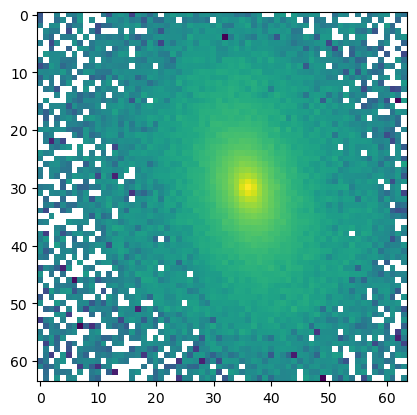

In [28]:
plt.imshow(np.log10(img_VIS))

We can make multiple lenses. The next task is to paint lenses into the Euclid ERO cutouts of the Perseus cluster. This is done in the *Lens_Dataset.ipynb* so refer to that notebook for painting in the lenses. However, we need to save the lenses first and we choose to save them with a *.fits* extension.

In [29]:
# make many more!!
i = 0
end = 5 # make a lot more than 5!
# save to YOUR directory
loc = wdir+'Data/Euclid-JWST/'
file_name = '_lens.fits'
while i < end:
    # generate the lenses
    img_VIS, img_NISP, image_VIS, image_J, image_Y, image_H, arr_params, countMod = CreateCompoundLenses(cosmo)
    name_out = str(i)+file_name
    
    # now let's write that to a .fits file and save
    fits.writeto(loc+'VIS/'+name_out, image_VIS, overwrite=True)
    fits.writeto(loc+'NISP-J/'+name_out, image_J, overwrite=True)
    fits.writeto(loc+'NISP-Y/'+name_out, image_Y, overwrite=True)
    fits.writeto(loc+'NISP-H/'+name_out, image_H, overwrite=True)
    i += countMod
print('Done!')

Done!


As a result you should see the following output. These are grayscale outputs from the *img_VIS*.

![lens examples](images/Unknown.pdf)